# 线性回归模型

需要的参数：
- 训练数据维度  c_in    int
- 输出数据维度  c_out   int
- 初始化均值    init_mean   float
- 初始化方差    init_var    float
- 是否带有偏置项    bias    bool

基类模型 LogicRegressor

如果不带有偏置项,即为$y = w^T x$, 如果带有偏置项为$y = w^Tx + b$.

计算损失使用MSE损失,即$l = \frac{1}{2N} \sum_{i} (\hat y_i - y_i)^2$.


- __init__初始化模型的c_in,c_out,bias，设定无权重输入下为随机分布
- predict计算在给定权重下的预测值
- loss为mseloss，计算给定预测和实际值的loss



In [1]:
import numpy as np
import utils
class LinearRegressor():
    def __init__(self,
        c_in:int,c_out:int,
        init_mean:float,init_var:float,
        bias:bool=True):

        self.c_in = c_in
        self.c_out = c_out
        self.bias=bias
        # 如果有偏置，权重的大小为(c_in+1,c_out)，否则为(c_in,c_out)
        if bias :
            weight_size = (c_in+1,c_out)
        else:
            weight_size = (c_in,c_out)
        
        # 初始化权重按照正态分布，均值为init_mean，方差为init_var
        self.weight = np.random.normal(init_mean,init_var,size=weight_size)

    def predict(self,
        x:np.ndarray,weight:np.ndarray=None
    )->np.ndarray:
        b = x.shape[0]

        # 检查是否需要偏置项，增加模型的表达能力
        if self.bias and x.shape[1] == self.c_in:
            x = np.concatenate([x, np.ones((b, 1))], axis=1)

        # 如果没有传入权重，使用模型的权重
        if weight is None:
            return np.matmul(x, self.weight)
        else:
            return np.matmul(x, weight)
        
    def loss(self,
        x:np.ndarray,y:np.ndarray
    )->np.ndarray:
        b = x.shape[0]
        if self.bias and x.shape[1] == self.c_in:
            x = np.concatenate([x, np.ones((b, 1))], axis=1)
        #计算y预测值，loss为MSELOSS
        y_hat = self.predict(x)
        loss_val = np.sum((y_hat - y) ** 2) / (2 * b)

        return loss_val


引入数据

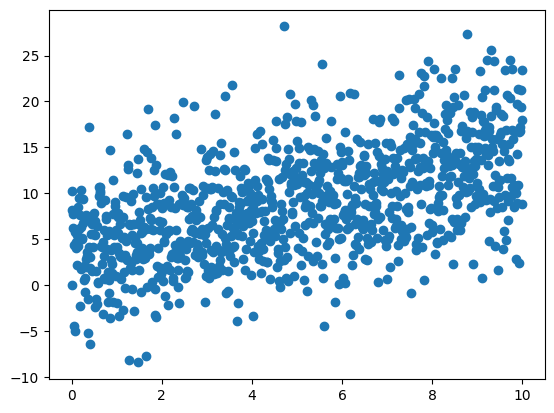

In [2]:
import numpy as np
filename='./linear_data_0302_1217.npy'
data = np.load(filename)

x_data=data[0,:,np.newaxis]
y_data=data[1,:,np.newaxis]

x_train,y_train,x_test,y_test=utils.split_data(x_data,y_data,split_ratio=0.8,shuffle=True)
utils.paint(x_data,y_data)


**上述定义了基本线性模型，接下来引入不同的预测方法。**

## 最小二乘法

最小二乘法的基本原理是寻找一条直线（或其他曲线）使得所有数据点到该直线的垂直距离（或曲线）的平方和最小。这种方法在处理超定系统（即方程数量大于未知数数量的情况）时非常有效，因为它能够提供一种方法来找到这些方程组的最佳近似解。

设线性回归模型为$h_{w}(x)$。在该模型中，θ是模型的参数，x是输入的自变量，n是x的维度。模型根据输入的X，给出预测值$h_w(x)$

根据$MSELoss=J(w)$，使得$\frac{\partial}{\partial w}J(w)=0$，即$\frac{\partial (y-x*w)^T(y-X*w)}{w} $

所以权重计算为$w = (x^Tx)^{-1}x^Ty$.


In [3]:
class LeastSquareRegressor(LinearRegressor):
    def __init__(self,
        c_in:int,c_out:int,
        init_mean:float,init_var:float,
        bias:bool=True):
        super(LeastSquareRegressor, self).__init__(c_in,c_out,init_mean,init_var,bias)

    def fit(self,
        x:np.ndarray,y:np.ndarray
    )->np.ndarray:
        b = x.shape[0]
        if self.bias and x.shape[1] == self.c_in:
            x = np.concatenate([x, np.ones((b, 1))], axis=1)
        # 最小二乘法求解权重
        self.weight = np.matmul(np.linalg.pinv(np.matmul(x.T, x)), np.matmul(x.T, y))
        return self.weight

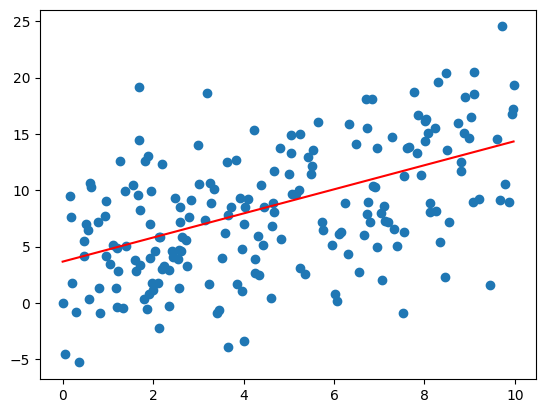

In [4]:
model=LeastSquareRegressor(x_data.shape[1],y_data.shape[1],0,0.1,True)
model.fit(x_train,y_train)

utils.display(x_test, y_test, model)

## 梯度下降法

每一步迭代中，沿着负梯度的方向（即下降最快的方向）移动一定的步长，直到达到损失函数的最小值。这个过程中，学习率（步长）的控制非常重要，因为太大的学习率可能导致算法发散，而太小的学习率又可能导致收敛速度过慢。

In [5]:
class GradientDescentRegressor(LinearRegressor):
    def __init__(self, c_in: int, c_out: int, init_mean: float, init_var: float, bias: bool = True):
        super().__init__(c_in, c_out, init_mean, init_var, bias)

    def fit(self,
        x: np.ndarray, y: np.ndarray, 
        lr: float, epochs: int,
        if_print:bool) -> np.ndarray:

        '''
        @param:
        x: np.ndarray, shape=(b, c_in), 输入数据
        y: np.ndarray, shape=(b, c_out), 标签数据
        lr: float, 学习率
        epochs: int, 迭代次数
        if_print: bool, 是否打印训练过程

        @return:
        np.ndarray, shape=(c_in+1, c_out), 权重
        '''
        b = x.shape[0]
        if self.bias and x.shape[1] == self.c_in:
            x = np.concatenate([x, np.ones((b, 1))], axis=1)
        
        for idx in range(epochs):
            y_hat = self.predict(x)
            grad = 2 * np.matmul(x.transpose(), y_hat - y) / b

            self.weight = self.weight - lr * grad
            if if_print:
                print(f'Epochs {idx+1}/{epochs}, Loss: {self.loss(x, y)}')

        return self.weight
    


Epochs 1/1000, Loss: 54.20263841555687
Epochs 2/1000, Loss: 48.75749059040761
Epochs 3/1000, Loss: 44.05043193810624
Epochs 4/1000, Loss: 39.981388616230134
Epochs 5/1000, Loss: 36.46385532203028
Epochs 6/1000, Loss: 33.423055598193606
Epochs 7/1000, Loss: 30.794351574061967
Epochs 8/1000, Loss: 28.5218693225316
Epochs 9/1000, Loss: 26.557310598321028
Epochs 10/1000, Loss: 24.85892568703741
Epochs 11/1000, Loss: 23.390625520788916
Epochs 12/1000, Loss: 22.121214177849495
Epochs 13/1000, Loss: 21.023725444070784
Epochs 14/1000, Loss: 20.074849326800084
Epochs 15/1000, Loss: 19.25443632506886
Epochs 16/1000, Loss: 18.545068913445938
Epochs 17/1000, Loss: 17.93169112637219
Epochs 18/1000, Loss: 17.40128836540641
Epochs 19/1000, Loss: 16.942610619895227
Epochs 20/1000, Loss: 16.545933214845647
Epochs 21/1000, Loss: 16.20284999786409
Epochs 22/1000, Loss: 15.906094566901976
Epochs 23/1000, Loss: 15.649385736887348
Epochs 24/1000, Loss: 15.42729395880634
Epochs 25/1000, Loss: 15.235125850390

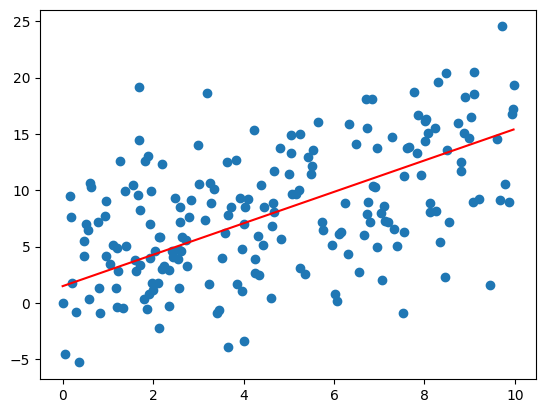

In [6]:
model_gd = GradientDescentRegressor(x_data.shape[1], y_data.shape[1], 0, 0.1, True)
model_gd.fit(x_train, y_train, 0.001, 1000, True)

utils.display(x_test, y_test, model_gd)

## 模拟退火法

模拟退火算法(Simulated Annealing, SA)的思想借鉴于固体的退火原理，当固体的温度很高的时候，内能比较大，固体的内部粒子处于快速无序运动，当温度慢慢降低的过程中，固体的内能减小，粒子的慢慢趋于有序，最终，当固体处于常温时，内能达到最小，此时，粒子最为稳定。模拟退火算法便是基于这样的原理设计而成。

模拟退火算法从某一较高的温度出发，这个温度称为初始温度，伴随着温度参数的不断下降，算法中的解趋于稳定，但是，可能这样的稳定解是一个局部最优解，此时，模拟退火算法中会以一定的概率跳出这样的局部最优解，以寻找目标函数的全局最优解。

- 外循环就是退火过程，将固体达到较高的温度（初始温度$T_0$），按照降温系数使温度按照一定比例下降，到达终止温度退火过程结束。
- 内循环是Metropolis算法，每次温度下，迭代L次寻找该温度下能量的最小值，温度不发生变化能量发生变化。
  - 如果解更好，则P=1接受
  - 如果解不够好，则$P=e^{E(n+1)-E(n)/T}$接受。

**!!!代码看起来挺对的感觉找出来的weight不是很对 不太清楚**

In [29]:
from copy import deepcopy

class SimulatedAnnealing(LinearRegressor):
    def __init__(self, c_in, c_out, init_mean, init_var, bias) -> None:
        super().__init__(c_in, c_out, init_mean, init_var, bias)
        self.model = GradientDescentRegressor(c_in, c_out, init_mean, init_var, bias)

    def fit(self,
        x: np.ndarray, y: np.ndarray,
        epochs: int, rounds: int,
        T: float, lr: float, decay: float,
        if_print: bool) -> np.ndarray:
        '''
        @param:
        x: np.ndarray, shape=(b, c_in), 输入数据
        y: np.ndarray, shape=(b, c_out), 标签数据
        epochs: int, 迭代次数
        rounds: int, 退火轮数
        T: float, 初始温度
        lr: float, 学习率
        decay: float, 退火速率
        if_print: bool, 是否打印训练过程
        '''
        self.model.fit(x,y,lr=lr,epochs=1000,if_print=False)
        best_model = deepcopy(self.model)
        best_loss = self.model.loss(x, y)

        if if_print:
            print(f'Initial Loss: {best_loss}')

        for epoch in range(epochs):
            for round in range(rounds):
                # 在模型参数的邻域内产生新的模型
                new_model = deepcopy(self.model)
                permute=np.random.normal(0,T,size=self.model.weight.shape)
                new_model.weight += np.random.normal(scale=lr, size=self.model.weight.shape)

                # 计算新模型的损失
                new_loss = new_model.loss(x, y)

                # 如果新模型的损失更小，或者满足Metropolis准则，则接受新模型
                if new_loss < best_loss or np.random.rand() < np.exp((best_loss - new_loss) / T):
                    self.model = new_model
                    best_loss = new_loss

                # 降低温度
                T *= decay

            if if_print:
                print(f'Epoch {epoch + 1}: Loss = {best_loss}')

        return best_loss
        

Initial Loss: 12.554026349415553
Epoch 1: Loss = 12.618478020260907
Epoch 2: Loss = 12.555937381580575
Epoch 3: Loss = 12.596582398918306
Epoch 4: Loss = 12.569285320594394
Epoch 5: Loss = 12.554454049611822
Epoch 6: Loss = 12.555801352886606
Epoch 7: Loss = 12.554514772501147
Epoch 8: Loss = 12.553989731171534
Epoch 9: Loss = 12.554162381730261
Epoch 10: Loss = 12.553936855810816
Epoch 11: Loss = 12.553937852751073
Epoch 12: Loss = 12.5539298712753
Epoch 13: Loss = 12.55392350542152
Epoch 14: Loss = 12.55392350542152
Epoch 15: Loss = 12.55392350542152
Epoch 16: Loss = 12.55392252998257
Epoch 17: Loss = 12.553922499844951
Epoch 18: Loss = 12.553922005536911
Epoch 19: Loss = 12.553922005536911
Epoch 20: Loss = 12.553922005536911
Epoch 21: Loss = 12.553922005536911
Epoch 22: Loss = 12.553922005536911
Epoch 23: Loss = 12.553922005536911
Epoch 24: Loss = 12.553922005536911
Epoch 25: Loss = 12.553922005536911
Epoch 26: Loss = 12.553922005536911
Epoch 27: Loss = 12.553922005536911
Epoch 28: 

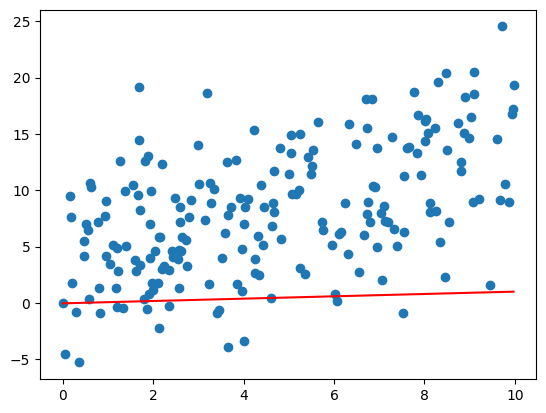

In [30]:
model_SA=SimulatedAnnealing(x_data.shape[1],y_data.shape[1],0,0.1,True)
model_SA.fit(x_train,y_train,100,100,1,0.01,0.99,True)

utils.display(x_test, y_test, model_SA)